In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel('cookie_cats.xlsx')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
### sum_gamerounds: 自从下载游戏第一周玩了多少关
#retention_1：当天是否离开
#retention_7： 7天后是否离开

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [5]:
df.groupby("version")["userid"].count()

version
gate_30    44700
gate_40    45489
Name: userid, dtype: int64

C:\Users\keden\AppData\Local\Temp\ipykernel_3304\2847354953.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["sum_gamerounds"], kde=True)


<Axes: xlabel='sum_gamerounds', ylabel='Density'>

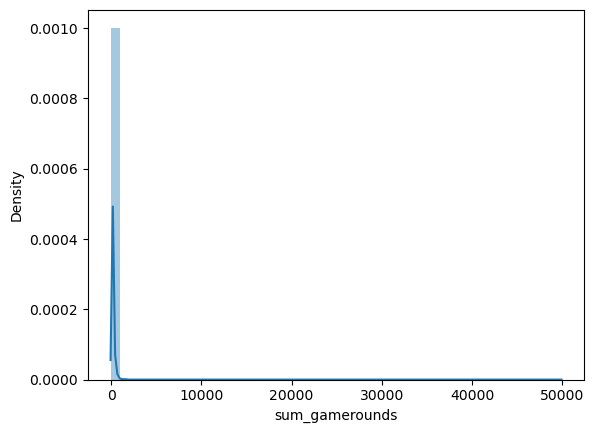

In [6]:
sns.distplot(df["sum_gamerounds"], kde=True)

In [7]:
df["sum_gamerounds"].sort_values(ascending=False)

57702    49854
7912      2961
29417     2640
43671     2438
48188     2294
         ...  
59687        0
23707        0
59670        0
59645        0
45094        0
Name: sum_gamerounds, Length: 90189, dtype: int64

In [8]:
plot_df=df.groupby("sum_gamerounds")["userid"].count().reset_index()
plot_df[plot_df["userid"]==1]

,sum_gamerounds,userid
448,448,1
471,471,1
501,501,1
522,522,1
533,533,1
...,...,...
937,2294,1
938,2438,1
939,2640,1
940,2961,1


In [9]:
df[df["sum_gamerounds"]==49854]

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True


In [10]:
df.drop(57702,axis=0, inplace=True)

In [11]:
df[df["sum_gamerounds"]==49854]

,userid,version,sum_gamerounds,retention_1,retention_7


In [12]:
# df["userid"].value_counts().sort_values(ascending=False)

In [13]:
# mean_rounds_retention_1 = df.groupby('retention_1')['sum_gamerounds'].mean()
# mean_rounds_retention_7 = df.groupby('retention_7')['sum_gamerounds'].mean()

In [15]:
# sns.pairplot(data=df,hue="version")

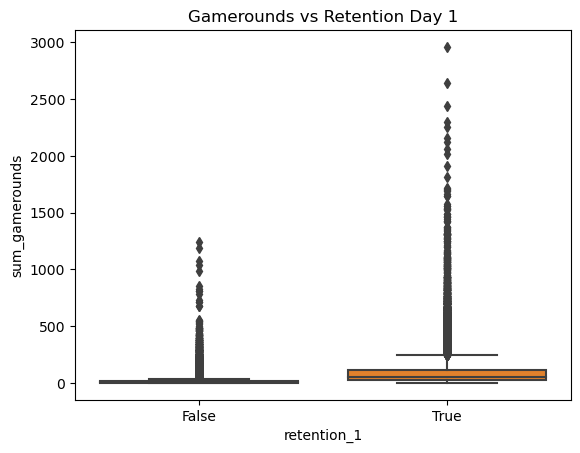

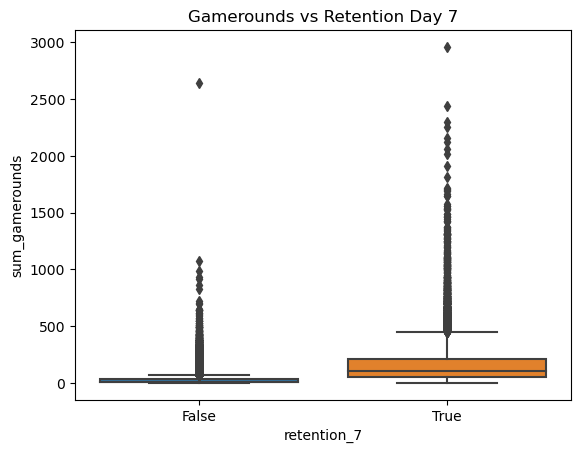

In [14]:
sns.boxplot(x=df['retention_1'], y=df['sum_gamerounds'])
plt.title('Gamerounds vs Retention Day 1')
plt.show()
sns.boxplot(x=df['retention_7'], y=df['sum_gamerounds'])
plt.title('Gamerounds vs Retention Day 7')
plt.show()

In [15]:
result_retention_1=df.groupby("version").agg(
    userid_count=("userid","count"),
    retention_count_1d=("retention_1","sum"),
    retention_rate_1d=("retention_1","mean") 
    )
result_retention_1

,userid_count,retention_count_1d,retention_rate_1d
version,,,
gate_30,44699,20034,0.448198
gate_40,45489,20119,0.442283


In [16]:
result_retention_7=df.groupby("version").agg(
    userid_count=("userid","count"),
    retention_count_7d=("retention_7","sum"),
    retention_rate_7d=("retention_7","mean") 
    )
result_retention_7

,userid_count,retention_count_7d,retention_rate_7d
version,,,
gate_30,44699,8501,0.190183
gate_40,45489,8279,0.182000


## Comparing 1-day Retention

h0: day1 retention rate of gate_30 <=gate40
ha：day1 retention rate of gate 40 > gate 30

### method1: mannual z-score

In [17]:
p_30_retention1=result_retention_1.loc["gate_30","retention_rate_1d"]
p_40_retention1=result_retention_1.loc["gate_40","retention_rate_1d"]

n_30_retention1=result_retention_1.loc["gate_30","userid_count"]
n_40_retention1=result_retention_1.loc["gate_40","userid_count"]

x_30_retention1=result_retention_1.loc["gate_30","retention_count_1d"]
x_40_retention1=result_retention_1.loc["gate_40","retention_count_1d"]

In [18]:
def z_test(p1,p0,n1,n0):
    delta=p1-p0
    p=(p1*n1+p0*n0)/(n1+n0)
    return delta/np.sqrt(p*(1-p)*(1/n1+1/n0))

In [19]:
z_score_retention_1d=z_test(p_40_retention1,p_30_retention1,n_40_retention1,n_30_retention1)
z_score_retention_1d

-1.787103509763628

In [20]:
from scipy.stats import norm
p_value_retention_1d=1-norm.cdf(z_score_retention_1d)
p_value_retention_1d

0.9630396198290827

###  method 2: package

In [23]:
import statsmodels.api as sm

In [25]:
z_score_retention_1d,p_value_retention_1d=sm.stats.proportions_ztest([x_40_retention1,x_30_retention1],[n_40_retention1,n_30_retention1],alternative="larger")
z_score_retention_1d,p_value_retention_1d

(-1.787103509763628, 0.9630396198290827)

### method 3: boostrapping

In [26]:
df.sample(frac = 1,replace = True).groupby("version")["retention_1"].mean()

version
gate_30    0.453307
gate_40    0.437115
Name: retention_1, dtype: float64

In [33]:
boostrap_list_1d=[]
for i in range(1000):
    bootmean=df.sample(frac = 1,replace = True).groupby("version")["retention_1"].mean()
    boostrap_list_1d.append(bootmean)

In [34]:
boostrap_1d=pd.DataFrame(boostrap_list_1d)
boostrap_1d.head()

version,gate_30,gate_40
retention_1,0.448899,0.445389
retention_1,0.450488,0.440853
retention_1,0.450065,0.438621
retention_1,0.448304,0.444776
retention_1,0.449808,0.440956


<Axes: ylabel='Density'>

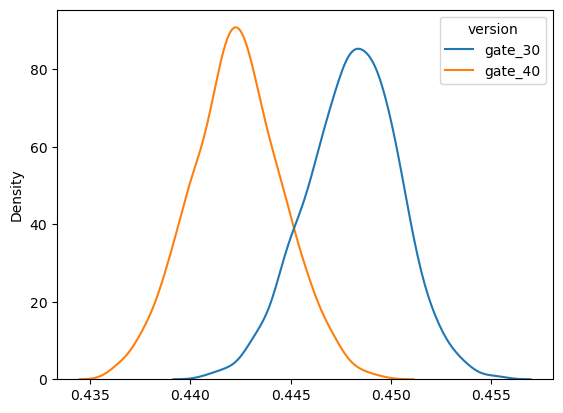

In [35]:
sns.kdeplot(boostrap_1d)

In [36]:
boostrap_1d["diff"]=(boostrap_1d["gate_30"]-boostrap_1d["gate_40"])/boostrap_1d["gate_40"]*100

Text(0.5, 1.0, '% different in 1day retation rate between gate_30 and gate 40')

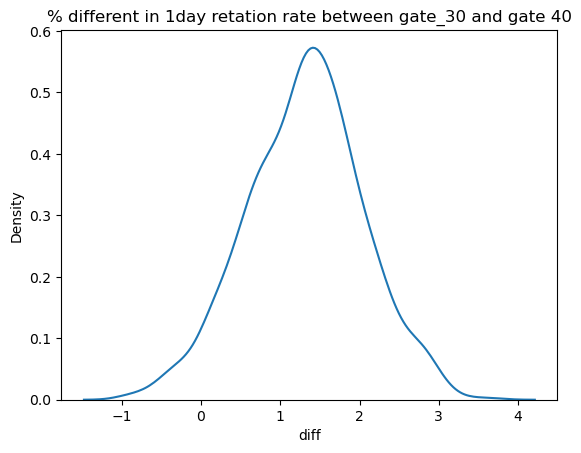

In [37]:
sns.kdeplot(boostrap_1d["diff"])
plt.title("% different in 1 day retation rate between gate_30 and gate 40")

In [38]:
(boostrap_1d["diff"]>0).mean()

0.963

#### From this chart, we can see that the most likely % difference is around 1% - 2%, and that 96% of the distribution is above 0%, in favor of a gate at level 30. 

## Comparing 7-day Retention

### method1: mannual z-score

h0: day 7 retention rate of gate_30 <=gate40
ha：day 7 retention rate of gate 40 > gate 30

In [39]:
result_retention_7

,userid_count,retention_count_7d,retention_rate_7d
version,,,
gate_30,44699,8501,0.190183
gate_40,45489,8279,0.182000


In [40]:
x_30_retention7=result_retention_7.loc["gate_30","retention_count_7d"]
x_40_retention7=result_retention_7.loc["gate_40","retention_count_7d"]

n_30_retention7=result_retention_7.loc["gate_30","userid_count"]
n_40_retention7=result_retention_7.loc["gate_40","userid_count"]

p_30_retention7=result_retention_7.loc["gate_30","retention_rate_7d"]
p_40_retention7=result_retention_7.loc["gate_40","retention_rate_7d"]

In [41]:
z_score=z_test(p_40_retention7,p_30_retention7,n_40_retention7,n_30_retention7)
z_score

-3.1574100858819936

In [42]:
p_value=1-norm.cdf(z_score)
p_value

0.9992041134113003

###  method 2: package

In [43]:
import statsmodels.api as sm
z_score,p_value=sm.stats.proportions_ztest([x_40_retention7,x_30_retention7],[n_40_retention7,n_30_retention7],alternative="larger")
z_score,p_value

(-3.1574100858819936, 0.9992041134113003)

### method 3: boostrapping

In [44]:
boostrap_list_7d=[]
for i in range(1000):
    boostmean=df.sample(frac=1,replace=True).groupby('version')["retention_7"].mean()
    boostrap_list_7d.append(boostmean)

<Axes: ylabel='Density'>

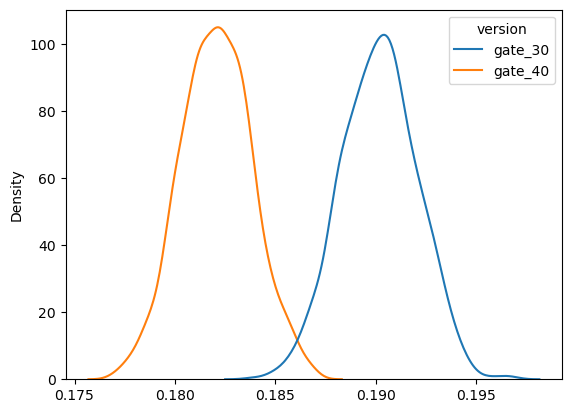

In [45]:
boostrap_7d=pd.DataFrame(boostrap_list_7d)
sns.kdeplot(boostrap_7d)

In [46]:
boostrap_7d.head()

version,gate_30,gate_40
retention_7,0.187711,0.180977
retention_7,0.189793,0.184013
retention_7,0.188971,0.182673
retention_7,0.188194,0.184014
retention_7,0.190260,0.182269


In [47]:
boostrap_7d["diff"]=(boostrap_7d["gate_30"]-boostrap_7d["gate_40"])/boostrap_7d["gate_40"]*100

<Axes: xlabel='diff', ylabel='Density'>

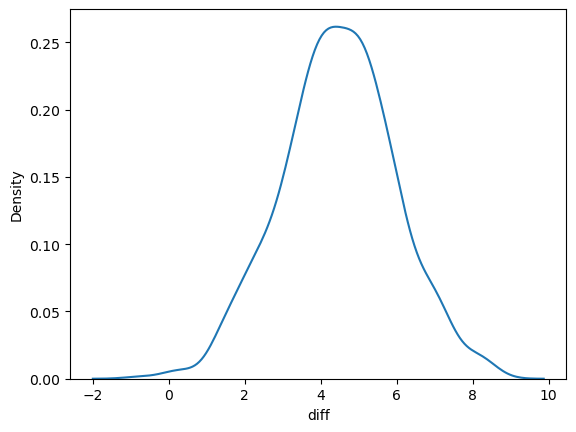

In [48]:
sns.kdeplot(boostrap_7d["diff"])

In [49]:
(boostrap_7d["diff"]>0).mean()

0.998

#### From this chart, we can see that the most likely % difference is around 2% - 6%, and that 99% of the distribution is above 0%, in favor of a gate at level 30. 